In [1]:
!pip install tqdm


In [2]:
!pip install tensorflow


In [3]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # for progress bars

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# TensorFlow / Keras for deep feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [5]:
dataset_path = r"C:\Users\ATHARVA\Downloads\Cat Dog Dataset\kagglecatsanddogs_3367a\PetImages"
# VGG16 default input size
IMG_SIZE = 224  


In [6]:
def load_images_for_vgg(path, img_size):
    data, labels = [], []
    categories = ["Cat", "Dog"]
    for category in categories:
        folder = os.path.join(path, category)
        label = 0 if category == "Cat" else 1
        if not os.path.exists(folder):
            print(f"Warning: Folder '{folder}' not found!")
            continue
        
        print(f"Loading {category} images from: {folder}")
        for img_name in tqdm(os.listdir(folder), desc=f"Loading {category} images"):
            img_path = os.path.join(folder, img_name)
            try:
                # Load image in color mode
                img = load_img(img_path, target_size=(img_size, img_size))
                img = img_to_array(img)
                data.append(img)
                labels.append(label)
            except Exception as e:
                # Skip image if there's an error
                continue
    return np.array(data), np.array(labels)

# Load images
X_raw, y = load_images_for_vgg(dataset_path, IMG_SIZE)
print(f"Total images loaded: {len(X_raw)}")
print(f"Labels distribution: Cats={np.sum(y==0)}, Dogs={np.sum(y==1)}")


Loading Cat images from: C:\Users\ATHARVA\Downloads\Cat Dog Dataset\kagglecatsanddogs_3367a\PetImages\Cat


Loading Cat images: 100%|██████████| 12491/12491 [02:41<00:00, 77.11it/s]


Loading Dog images from: C:\Users\ATHARVA\Downloads\Cat Dog Dataset\kagglecatsanddogs_3367a\PetImages\Dog


Loading Dog images:  91%|█████████▏| 11404/12470 [02:24<00:12, 86.90it/s]C:\Users\ATHARVA\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Loading Dog images: 100%|██████████| 12470/12470 [02:37<00:00, 78.98it/s]


Total images loaded: 24959
Labels distribution: Cats=12490, Dogs=12469


In [7]:
# Preprocess images using VGG16's preprocess_input
X_preprocessed = preprocess_input(X_raw)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 19967, Testing samples: 4992


In [8]:
# Load VGG16 model with weights pre-trained on ImageNet
# include_top=False removes the fully connected layers at the top
# pooling='avg' applies global average pooling on the output features
vgg_model = VGG16(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

def extract_features(model, X):
    features = model.predict(X, verbose=1)
    return features

print("Extracting features for training set...")
X_train_features = extract_features(vgg_model, X_train)

print("Extracting features for test set...")
X_test_features = extract_features(vgg_model, X_test)

print(f"Feature shape (train): {X_train_features.shape}")
print(f"Feature shape (test): {X_test_features.shape}")


Extracting features for training set...
624/624 ━━━━━━━━━━━━━━━━━━━━ 4998s 8s/step
Extracting features for test set...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1910s 12s/step
Feature shape (train): (19967, 512)
Feature shape (test): (4992, 512)


In [22]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Create an SVM classifier (you can experiment with different kernels and hyperparameters)
svm_model = SVC(kernel="linear", C=1.0, verbose=True)

# Measure training time
start_time = time.time()
svm_model.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")


[LibSVM]Training completed in 36.34 seconds


In [24]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate and print test accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 98.04%


In [32]:
import numpy as np
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))


{0: 2538, 1: 2454}


In [36]:
# Assuming X_raw and y are already defined from your image-loading step:
from sklearn.model_selection import train_test_split

# Split the raw images along with the labels (and you can also split preprocessed images separately if needed)
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)


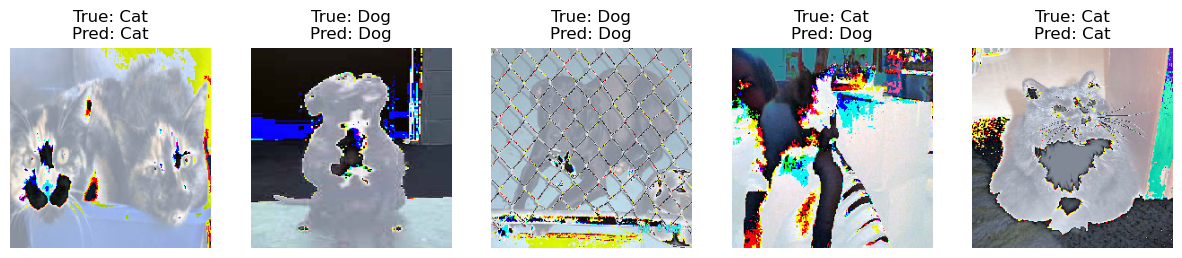

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(original_images, true_labels, preds, num=5):
    indices = np.random.choice(len(original_images), size=num, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num, i + 1)
        img = original_images[idx].astype("uint8")
        plt.imshow(img)
        plt.title(f"True: {'Dog' if true_labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if preds[idx] == 1 else 'Cat'}")
        plt.axis("off")
    plt.show()

# Use the raw test images, true test labels, and predicted labels:
plot_predictions(X_raw_test, y_test, y_pred, num=5)
